# HW3 Practical: Comparing Generative Paradigms on CIFAR-10


Welcome! This notebook provides the training and evaluation pipeline for the four generative models you will build in `models/`.

- Run the setup cells to install dependencies and load CIFAR-10.
- Complete the TODOs in the Python modules, verify with Gradescope autograder, then return here to train and evaluate models.
- Follow the prompts in each section to log results and save artefacts (sample image grids, metrics, and plots) for inclusion in your PDF report.


In [1]:
# Install lightweight dependencies (safe to re-run)
%pip install --quiet torch-fidelity tqdm


Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import time
from pathlib import Path
from collections import defaultdict

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from tqdm.auto import tqdm

from cifar10 import load_cifar10
from models.gan import DCGAN
from models.vae import ConvVAE
from models.pixelcnn import PixelCNN
from models.ddpm import DenoiseUNet

from torch_fidelity import calculate_metrics

c:\Users\Guill\Anaconda3\envs\lensingtest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Global configuration
PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

BATCH_SIZE = 128
NUM_WORKERS = 2
IMAGE_SIZE = 32
NUM_CLASSES = 10

print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_name}")
print(f"Project root: {PROJECT_ROOT}")


Using device: cuda
GPU: NVIDIA GeForce RTX 2060
Project root: g:\My Drive\Temporary files\RL_assignment3\Q1\IFT6135-A2025-HW-3


### Experiment presets

The dictionaries below define the baseline ("small") and scaled ("medium") configurations used in the assignment. Baselines train for 30 epochs, and the scaled variants run for 40 epochs so you can contrast added capacity with extra compute. Feel free to explore other values.


In [4]:
EXPERIMENT_CONFIGS = {
    "dcgan": {
        "small": {"base_channels": 64, "latent_dim": 128, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "latent_dim": 128, "epochs": 40, "lr": 2e-4},
    },
    "vae": {
        "small": {"base_channels": 64, "latent_dim": 128, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "latent_dim": 192, "epochs": 40, "lr": 2e-4},
    },
    "pixelcnn": {
        "small": {"hidden_channels": 64, "residual_layers": 5, "epochs": 30, "lr": 3e-4},
        "medium": {"hidden_channels": 96, "residual_layers": 7, "epochs": 40, "lr": 3e-4},
    },
    "ddpm": {
        "small": {"base_channels": 64, "time_channels": 256, "timesteps": 1000, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "time_channels": 256, "timesteps": 750, "epochs": 40, "lr": 2e-4},
    },
}

EXPERIMENT_CONFIGS


{'dcgan': {'small': {'base_channels': 64,
   'latent_dim': 128,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'latent_dim': 128,
   'epochs': 40,
   'lr': 0.0002}},
 'vae': {'small': {'base_channels': 64,
   'latent_dim': 128,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'latent_dim': 192,
   'epochs': 40,
   'lr': 0.0002}},
 'pixelcnn': {'small': {'hidden_channels': 64,
   'residual_layers': 5,
   'epochs': 30,
   'lr': 0.0003},
  'medium': {'hidden_channels': 96,
   'residual_layers': 7,
   'epochs': 40,
   'lr': 0.0003}},
 'ddpm': {'small': {'base_channels': 64,
   'time_channels': 256,
   'timesteps': 1000,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'time_channels': 256,
   'timesteps': 750,
   'epochs': 40,
   'lr': 0.0002}}}

In [5]:
THROUGHPUT_SAMPLES = {
    "dcgan": 1024,
    "vae": 1024,
    "pixelcnn": 1024,  # autoregressive sampling is slow; document your actual sample count if you change this
    "ddpm": 1024,
}

THROUGHPUT_SAMPLES


{'dcgan': 1024, 'vae': 1024, 'pixelcnn': 1024, 'ddpm': 1024}

## Data loading


In [6]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=True,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=False,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, val_loader


set_seed(SEED)
train_loader, val_loader = get_dataloaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 391, Validation batches: 79


In [7]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=True,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=False,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, val_loader


set_seed(SEED)
train_loader, val_loader = get_dataloaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 391, Validation batches: 79


## Utility functions


In [8]:
def to_device(batch, device=DEVICE):
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}


def images_to_uint8(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor.detach().cpu().clamp(0.0, 1.0)
    tensor = (tensor * 255.0).round().to(torch.uint8)
    return tensor.permute(0, 2, 3, 1).numpy()


def save_image_grid(images: torch.Tensor, path: Path, nrow: int = 8):
    path.parent.mkdir(parents=True, exist_ok=True)
    grid = make_grid(images.detach().cpu(), nrow=nrow, padding=2)
    save_image(grid, str(path))
    return grid


def gather_real_images(loader: DataLoader, max_samples: int = 2048) -> torch.Tensor:
    batches = []
    total = 0
    for batch in loader:
        imgs = batch["images"]
        batches.append(imgs)
        total += imgs.size(0)
        if total >= max_samples:
            break
    return torch.cat(batches, dim=0)[:max_samples]


def compute_kid_score(real_images: torch.Tensor, fake_images: torch.Tensor) -> float:
    real_np = images_to_uint8(real_images)
    fake_np = images_to_uint8(fake_images)


    from torch.utils.data import Dataset

    class _ArrayDataset(Dataset):
        def __init__(self, array: np.ndarray):
            self.array = array

        def __len__(self) -> int:
            return self.array.shape[0]

        def __getitem__(self, idx: int):
            arr = self.array[idx]
            tensor = torch.from_numpy(arr).permute(2, 0, 1).contiguous()
            return tensor

    print('running calculate_metrics')
    metrics = calculate_metrics(
        input1=_ArrayDataset(fake_np),
        input2=_ArrayDataset(real_np),
        kid=True,
        fid=False,
        cuda=True, # I set this to true
        save_cpu_ram=True
    )
    kid_key = "kernel_inception_distance_mean"
    if kid_key not in metrics:
        kid_key = "kid_mean"
    kid_value = metrics.get(kid_key)
    if kid_value is None:
        raise KeyError(f"KID metric missing expected keys: {list(metrics.keys())}")
    return float(kid_value)


def measure_sampling_throughput(sample_fn, num_images: int = 1024, device=DEVICE):
    torch.cuda.empty_cache()
    torch.cuda.synchronize() if device.type == "cuda" else None
    start = time.perf_counter()
    samples = sample_fn(num_images=num_images, device=device)
    torch.cuda.synchronize() if device.type == "cuda" else None
    elapsed = time.perf_counter() - start
    throughput = num_images / elapsed
    return samples, elapsed, throughput


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [9]:
real_subset = gather_real_images(val_loader, max_samples=2048)
real_subset_device = real_subset.to(DEVICE)
print(f"Real subset cached: {real_subset.shape} (device copy: {real_subset_device.shape})")



Real subset cached: torch.Size([2048, 3, 32, 32]) (device copy: torch.Size([2048, 3, 32, 32]))


## Training loops


In [10]:
def _init_history():
    return defaultdict(list)
  
def train_dcgan(model: DCGAN, dataloader: DataLoader, optimizer_g, optimizer_d, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[DCGAN] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)

            model.zero_grad(set_to_none=True)
            optimizer_d.zero_grad(set_to_none=True)
            out_d = model({"images": images})
            loss_d = out_d["discriminator_loss"]
            loss_d.backward()
            optimizer_d.step()

            model.zero_grad(set_to_none=True)
            optimizer_g.zero_grad(set_to_none=True)
            out_g = model({"images": images})
            loss_g = out_g["generator_loss"]
            loss_g.backward()
            optimizer_g.step()

            history["d_loss"].append(loss_d.item())
            history["g_loss"].append(loss_g.item())
            progress.set_postfix({"d": loss_d.item(), "g": loss_g.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_vae(model: ConvVAE, dataloader: DataLoader, optimizer, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[VAE] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            history["kl"].append(out["kl"].mean().item())
            history["recon"].append(out["reconstruction_loss"].mean().item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_pixelcnn(model: PixelCNN, dataloader: DataLoader, optimizer, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[PixelCNN] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_ddpm(model: DenoiseUNet, dataloader: DataLoader, optimizer, epochs: int = 1, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[DDPM] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history



## Sampling & evaluation helper functions


In [11]:
@torch.no_grad()
def sample_dcgan(model: DCGAN, num_samples: int = 64, device=DEVICE, batch_size: int = 64):
    model.eval()
    model.to(device)
    samples = []
    for start in range(0, num_samples, batch_size):
        n = min(batch_size, num_samples - start)
        z = torch.randn((n, model.latent_dim), device=device)
        fake = model.sample(z) ### TODO: sample from the model
        samples.append(fake.detach().cpu())
    return torch.cat(samples, dim=0)


@torch.no_grad()
def sample_vae(model: ConvVAE, num_samples: int = 64, device=DEVICE, batch_size: int = 64):
    model.eval()
    model.to(device)
    samples = []
    for start in range(0, num_samples, batch_size):
        n = min(batch_size, num_samples - start)
        z = torch.randn(n, model.latent_dim, device=device)
        mean, logvar = model.decode(z) ### TODO: decode the latent codes using the model
        std = torch.exp(0.5 * logvar)
        draw = torch.randn(mean.shape, device=std.device)*std + mean ### TODO: sample from the distribution
        samples.append(draw.detach().cpu())
    return torch.cat(samples, dim=0).clamp(0.0, 1.0)


@torch.no_grad()
def sample_pixelcnn(model: PixelCNN, num_samples: int = 16, device=DEVICE, image_size: int = IMAGE_SIZE):
    model.eval()
    model.to(device)
    bins = model.bins
    samples = torch.zeros(num_samples, model.image_channels, image_size, image_size, device=device)
    for row in range(image_size):
        for col in range(image_size):
            logits = model.net(samples) ### TODO get the logits from the model
            logits = logits.view(num_samples, model.image_channels, bins, image_size, image_size)
            probs = torch.nn.Softmax(dim=2)(logits[:,:,:,row,col]-torch.max(logits[:,:,:,row,col], dim=2, keepdim=True)[0]) ### TODO: Softmax the logits to get the probability of each bin
            cat = torch.distributions.Categorical(probs=probs)
            pixel = cat.sample()
            pixel = pixel.float() / (bins - 1)
            samples[:, :, row, col] = pixel
    return samples.detach().cpu().clamp(0.0, 1.0)


@torch.no_grad()
def _ddpm_predict_noise(model: DenoiseUNet, xt: torch.Tensor, t: torch.Tensor):
    time_emb = model.time_embedding(t)
    h0 = model.model["init"](xt) ### TODO: forward the input through the layers
    skip0, h1 = model.model["down0"](h0, time_emb) ### TODO
    skip1, h2 = model.model["down1"](h1, time_emb) ### TODO
    skip2, h3 = model.model["down2"](h2, time_emb) ### TODO
    h_mid = model.model["mid"](h3, time_emb) ### TODO
    h = model.model["up2"](h_mid, skip2, time_emb) ### TODO
    h = model.model["up1"](h, skip1, time_emb) ### TODO
    h = model.model["up0"](h, skip0, time_emb) ### TODO
    pred_noise = model.model["out"](h) ### TODO
    return pred_noise


@torch.no_grad()
def sample_ddpm(model: DenoiseUNet, num_samples: int = 64, device=DEVICE, timesteps: int = None):
    model.eval()
    model.to(device)
    T = timesteps if timesteps is not None else model.timesteps
    betas = model.betas.to(device)
    alphas = 1.0 - betas
    alphas_cumprod = model.alphas_cumprod.to(device)
    alphas_cumprod_prev = torch.cat([torch.ones(1, device=device), alphas_cumprod[:-1]])
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_one_minus_cumprod = torch.sqrt(1.0 - alphas_cumprod)

    xt = torch.randn(num_samples, model.image_channels, IMAGE_SIZE, IMAGE_SIZE, device=device)
    for step in reversed(range(T)):
        t = torch.full((num_samples,), step, device=device, dtype=torch.long)
        pred_noise = _ddpm_predict_noise(model, xt, t) ### TODO: predict the noise from the model
        beta_t = betas[step]
        sqrt_recip_alpha_t = sqrt_recip_alphas[step]
        sqrt_one_minus_cumprod_t = sqrt_one_minus_cumprod[step]
        model_mean = sqrt_recip_alpha_t * (xt - beta_t / sqrt_one_minus_cumprod_t * pred_noise)
        if step > 0:
            variance = beta_t * (1.0 - alphas_cumprod_prev[step]) / (1.0 - alphas_cumprod[step])
            noise = torch.randn_like(xt)
            xt = noise*torch.sqrt(variance) + model_mean ### TODO: update the image
        else:
            xt = model_mean
    return xt.detach().cpu().clamp(-1.0, 1.0)



## Experiment tracking utilities


In [12]:
experiment_log = {}


def record_metrics(model_name: str, variant: str, metrics: dict):
    experiment_log.setdefault(model_name, {})[variant] = metrics


def show_metrics(model_name: str = None):
    if model_name is None:
        for name in experiment_log:
            show_metrics(name)
        return
    print(f"=== {model_name} ===")
    entries = experiment_log.get(model_name, {})
    for variant, metrics in entries.items():
        print(f"  [{variant}]")
        for key, value in metrics.items():
            print(f"    {key}: {value}")
    if not entries:
        print("  (no entries yet)")


## DCGAN (adversarial generation)

Fill in the TODOs inside `models/gan.py` before running this section. The cells below:

1. Instantiate the model and optimizers.
2. Train for the baseline configuration.
3. Generate sample grids, measure KID, and record sampling throughput.
4. Repeat with the medium-scale variant


In [13]:
torch.cuda.empty_cache()
dcgan_cfg = EXPERIMENT_CONFIGS["dcgan"]["small"]
dcgan = DCGAN(
    image_channels=3,
    latent_dim=dcgan_cfg["latent_dim"],
    base_channels=dcgan_cfg["base_channels"],
)
optim_g = torch.optim.Adam(dcgan.generator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
optim_d = torch.optim.Adam(dcgan.discriminator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
print(f"Baseline DCGAN parameters: {count_parameters(dcgan):,}")


Baseline DCGAN parameters: 1,846,980


In [14]:
DCGAN_EPOCHS = dcgan_cfg["epochs"]

dcgan_history = train_dcgan(dcgan, train_loader, optimizer_g=optim_g, optimizer_d=optim_d, epochs=DCGAN_EPOCHS)
dcgan_epoch_times = dcgan_history["epoch_time"]  # populate this inside your implementation
dcgan_train_time = sum(dcgan_epoch_times)
print(f"Finished DCGAN training: {len(dcgan_history['d_loss'])} steps")
print(f"DCGAN training time per epoch (s): {[round(t, 2) for t in dcgan_epoch_times]}")


Finished DCGAN training: 11730 steps
DCGAN training time per epoch (s): [16.72, 16.46, 16.47, 16.6, 16.72, 16.16, 16.03, 16.04, 16.13, 16.13, 16.09, 16.4, 16.51, 16.36, 16.28, 16.39, 16.36, 16.39, 16.46, 16.44, 16.57, 16.85, 16.84, 16.46, 16.56, 16.57, 16.92, 16.6, 16.62, 16.62]


In [15]:
# TODO: run once `sample_dcgan` is implemented.
# Evaluation: sampling, KID, throughput
samples_64 = sample_dcgan(dcgan, num_samples=64, device=DEVICE)
samples_64_vis = (samples_64 + 1.0) / 2.0  # map from [-1, 1] to [0, 1]
save_image_grid(samples_64_vis, ARTIFACT_DIR / "dcgan_samples_baseline.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["dcgan"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DCGAN",
    "baseline",
    {
        "epochs": DCGAN_EPOCHS,
        "params": count_parameters(dcgan),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": dcgan_train_time,
        "train_time_per_epoch_s": dcgan_train_time / DCGAN_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")


running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

KID (x10^3): 0.054
Sampling time for 1024 images: 0.08 s (throughput 13208.3 img/s)


Kernel Inception Distance: 0.05439596176147461 ± 0.00024102694868396578


> **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("DCGAN", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [16]:
# MEDIUM CONFIG 30 EPOCHS

torch.cuda.empty_cache()
dcgan_cfg = EXPERIMENT_CONFIGS["dcgan"]["medium"]
dcgan = DCGAN(
    image_channels=3,
    latent_dim=dcgan_cfg["latent_dim"],
    base_channels=dcgan_cfg["base_channels"],
)
optim_g = torch.optim.Adam(dcgan.generator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
optim_d = torch.optim.Adam(dcgan.discriminator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
print(f"Medium DCGAN parameters: {count_parameters(dcgan):,}")

DCGAN_EPOCHS = 30

dcgan_history = train_dcgan(dcgan, train_loader, optimizer_g=optim_g, optimizer_d=optim_d, epochs=DCGAN_EPOCHS)
dcgan_epoch_times = dcgan_history["epoch_time"]  # populate this inside your implementation
dcgan_train_time = sum(dcgan_epoch_times)
print(f"Finished DCGAN training: {len(dcgan_history['d_loss'])} steps")
print(f"DCGAN training time per epoch (s): {[round(t, 2) for t in dcgan_epoch_times]}")

# TODO: run once `sample_dcgan` is implemented.
# Evaluation: sampling, KID, throughput
samples_64 = sample_dcgan(dcgan, num_samples=64, device=DEVICE)
samples_64_vis = (samples_64 + 1.0) / 2.0  # map from [-1, 1] to [0, 1]
save_image_grid(samples_64_vis, ARTIFACT_DIR / "dcgan_samples_medium_30epochs.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["dcgan"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DCGAN",
    "scaled-30ep",
    {
        "epochs": DCGAN_EPOCHS,
        "params": count_parameters(dcgan),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": dcgan_train_time,
        "train_time_per_epoch_s": dcgan_train_time / DCGAN_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")


Medium DCGAN parameters: 3,753,508


[DCGAN] Epoch 2/30:  49%|████▉     | 191/391 [00:15<00:12, 15.68it/s, d=1.07, g=0.583]  

Finished DCGAN training: 11730 steps
DCGAN training time per epoch (s): [27.41, 28.28, 28.45, 28.31, 28.1, 28.34, 28.42, 28.15, 28.13, 28.14, 28.26, 28.15, 28.29, 28.25, 28.58, 28.5, 28.68, 28.58, 28.63, 28.62, 28.66, 28.37, 28.39, 28.37, 28.36, 28.4, 28.53, 28.58, 28.45, 28.48]
running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

KID (x10^3): 0.051
Sampling time for 1024 images: 0.06 s (throughput 16652.6 img/s)


Kernel Inception Distance: 0.05065341234207153 ± 0.0002285830332855902


In [17]:
# MEDIUM CONFIG 40 EPOCHS

torch.cuda.empty_cache()
dcgan_cfg = EXPERIMENT_CONFIGS["dcgan"]["medium"]
dcgan = DCGAN(
    image_channels=3,
    latent_dim=dcgan_cfg["latent_dim"],
    base_channels=dcgan_cfg["base_channels"],
)
optim_g = torch.optim.Adam(dcgan.generator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
optim_d = torch.optim.Adam(dcgan.discriminator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
print(f"Medium DCGAN parameters: {count_parameters(dcgan):,}")

DCGAN_EPOCHS = 40

dcgan_history = train_dcgan(dcgan, train_loader, optimizer_g=optim_g, optimizer_d=optim_d, epochs=DCGAN_EPOCHS)
dcgan_epoch_times = dcgan_history["epoch_time"]  # populate this inside your implementation
dcgan_train_time = sum(dcgan_epoch_times)
print(f"Finished DCGAN training: {len(dcgan_history['d_loss'])} steps")
print(f"DCGAN training time per epoch (s): {[round(t, 2) for t in dcgan_epoch_times]}")

# TODO: run once `sample_dcgan` is implemented.
# Evaluation: sampling, KID, throughput
samples_64 = sample_dcgan(dcgan, num_samples=64, device=DEVICE)
samples_64_vis = (samples_64 + 1.0) / 2.0  # map from [-1, 1] to [0, 1]
save_image_grid(samples_64_vis, ARTIFACT_DIR / "dcgan_samples_medium_40epochs.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["dcgan"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DCGAN",
    "scaled-40ep",
    {
        "epochs": DCGAN_EPOCHS,
        "params": count_parameters(dcgan),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": dcgan_train_time,
        "train_time_per_epoch_s": dcgan_train_time / DCGAN_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")


Medium DCGAN parameters: 3,753,508


[DCGAN] Epoch 1/40:  62%|██████▏   | 241/391 [00:17<00:09, 16.04it/s, d=0.475, g=4.21]   

Finished DCGAN training: 15640 steps
DCGAN training time per epoch (s): [27.34, 28.05, 28.16, 28.12, 28.24, 28.35, 28.16, 28.24, 28.09, 28.19, 28.23, 28.23, 28.25, 28.75, 28.26, 28.25, 28.33, 28.31, 28.3, 28.27, 28.32, 28.38, 28.41, 28.35, 28.38, 28.4, 28.36, 28.4, 28.36, 28.41, 28.38, 28.39, 28.74, 28.41, 28.44, 28.56, 28.83, 28.85, 28.8, 28.54]
running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

KID (x10^3): 0.046
Sampling time for 1024 images: 0.06 s (throughput 16414.5 img/s)


Kernel Inception Distance: 0.046002395153045654 ± 0.00023235825436781316


## Convolutional VAE (latent variable model)

Make sure the loss components in `models/vae.py` are implemented before training.


In [18]:
torch.cuda.empty_cache()
vae_cfg = EXPERIMENT_CONFIGS["vae"]["small"]
vae = ConvVAE(
    image_channels=3,
    latent_dim=vae_cfg["latent_dim"],
    base_channels=vae_cfg["base_channels"],
)
optim_vae = torch.optim.Adam(vae.parameters(), lr=vae_cfg["lr"])
print(f"Baseline VAE parameters: {count_parameters(vae):,}")


Baseline VAE parameters: 3,518,214


In [19]:
VAE_EPOCHS = vae_cfg["epochs"]

vae_history = train_vae(vae, train_loader, optimizer=optim_vae, epochs=VAE_EPOCHS)
vae_epoch_times = vae_history["epoch_time"]  # populate this inside your implementation
vae_train_time = sum(vae_epoch_times)
print(f"Finished VAE training: {len(vae_history['loss'])} steps")
print(f"VAE training time per epoch (s): {[round(t, 2) for t in vae_epoch_times]}")


Finished VAE training: 11730 steps
VAE training time per epoch (s): [9.17, 9.25, 9.21, 9.26, 9.24, 9.24, 9.33, 9.3, 9.32, 9.35, 9.35, 9.26, 9.28, 9.41, 9.72, 9.45, 9.43, 9.35, 9.38, 9.44, 9.45, 9.44, 9.45, 9.46, 9.44, 9.43, 9.47, 9.46, 9.45, 9.43]


In [20]:
def evaluate_vae_elbo(model: ConvVAE, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = total_recon = total_kl = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += out["loss"].item() * batch_size
            total_recon += out["reconstruction_loss"].mean().item() * batch_size
            total_kl += out["kl"].mean().item() * batch_size
    return {
        "loss": total_loss / total_examples,
        "reconstruction": total_recon / total_examples,
        "kl": total_kl / total_examples,
    }


# TODO: once `sample_vae' are implemented, run the evaluation below.

vae_elbo = evaluate_vae_elbo(vae, val_loader)
vae_samples = sample_vae(vae, num_samples=64, device=DEVICE)
save_image_grid(vae_samples, ARTIFACT_DIR / "vae_samples_baseline.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["vae"]
vae_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:vae_samples_large.size(0)].cpu(), vae_samples_large.cpu())
record_metrics(
    "VAE",
    "baseline",
    {
        "epochs": VAE_EPOCHS,
        "params": count_parameters(vae),
        "kid": kid,
        "nll": vae_elbo["loss"],
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": vae_train_time,
        "train_time_per_epoch_s": vae_train_time / VAE_EPOCHS,
    },
)

print(f"Validation ELBO: {vae_elbo['loss']:.4f} (recon {vae_elbo['reconstruction']:.4f}, KL {vae_elbo['kl']:.4f})")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {vae_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")



running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

Validation ELBO: -3455.9166 (recon -3698.3825, KL 242.4660)
KID (x10^3): 0.296
Sampling time for 1024 images: 0.05 s (throughput 20973.6 img/s)


Kernel Inception Distance: 0.29605483531951904 ± 0.0005374878158164182


> **Scaling experiment:** Retrain the medium-scale configuration and log metrics after 30 and 40 epochs (e.g. `record_metrics("VAE", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [21]:
# MEDIUM CONFIG 30 EPOCHS

torch.cuda.empty_cache()
vae_cfg = EXPERIMENT_CONFIGS["vae"]["medium"]
vae = ConvVAE(
    image_channels=3,
    latent_dim=vae_cfg["latent_dim"],
    base_channels=vae_cfg["base_channels"],
)
optim_vae = torch.optim.Adam(vae.parameters(), lr=vae_cfg["lr"])
print(f"Medium VAE parameters: {count_parameters(vae):,}")

VAE_EPOCHS = 30

vae_history = train_vae(vae, train_loader, optimizer=optim_vae, epochs=VAE_EPOCHS)
vae_epoch_times = vae_history["epoch_time"]  # populate this inside your implementation
vae_train_time = sum(vae_epoch_times)
print(f"Finished VAE training: {len(vae_history['loss'])} steps")
print(f"VAE training time per epoch (s): {[round(t, 2) for t in vae_epoch_times]}")

def evaluate_vae_elbo(model: ConvVAE, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = total_recon = total_kl = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += out["loss"].item() * batch_size
            total_recon += out["reconstruction_loss"].mean().item() * batch_size
            total_kl += out["kl"].mean().item() * batch_size
    return {
        "loss": total_loss / total_examples,
        "reconstruction": total_recon / total_examples,
        "kl": total_kl / total_examples,
    }


# TODO: once `sample_vae' are implemented, run the evaluation below.

vae_elbo = evaluate_vae_elbo(vae, val_loader)
vae_samples = sample_vae(vae, num_samples=64, device=DEVICE)
save_image_grid(vae_samples, ARTIFACT_DIR / "vae_samples_medium_30epochs.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["vae"]
vae_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:vae_samples_large.size(0)].cpu(), vae_samples_large.cpu())
record_metrics(
    "VAE",
    "scaled-30ep",
    {
        "epochs": VAE_EPOCHS,
        "params": count_parameters(vae),
        "kid": kid,
        "nll": vae_elbo["loss"],
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": vae_train_time,
        "train_time_per_epoch_s": vae_train_time / VAE_EPOCHS,
    },
)

print(f"Validation ELBO: {vae_elbo['loss']:.4f} (recon {vae_elbo['reconstruction']:.4f}, KL {vae_elbo['kl']:.4f})")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {vae_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")



Medium VAE parameters: 7,906,950


[VAE] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished VAE training: 11730 steps
VAE training time per epoch (s): [28.04, 28.8, 29.25, 29.01, 29.08, 29.31, 29.27, 29.43, 29.12, 29.08, 29.08, 29.15, 29.49, 29.33, 29.15, 29.2, 29.17, 29.24, 29.22, 29.18, 29.29, 29.72, 29.68, 29.74, 29.67, 29.77, 29.77, 29.67, 29.69, 29.78]
running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

Validation ELBO: -3600.6160 (recon -3862.9967, KL 262.3807)
KID (x10^3): 0.294
Sampling time for 1024 images: 0.25 s (throughput 4133.8 img/s)


Kernel Inception Distance: 0.2939386534690857 ± 0.0005172791615755475


In [22]:
# MEDIUM CONFIG 40 EPOCHS

torch.cuda.empty_cache()
vae_cfg = EXPERIMENT_CONFIGS["vae"]["medium"]
vae = ConvVAE(
    image_channels=3,
    latent_dim=vae_cfg["latent_dim"],
    base_channels=vae_cfg["base_channels"],
)
optim_vae = torch.optim.Adam(vae.parameters(), lr=vae_cfg["lr"])
print(f"Medium VAE parameters: {count_parameters(vae):,}")

VAE_EPOCHS = 40

vae_history = train_vae(vae, train_loader, optimizer=optim_vae, epochs=VAE_EPOCHS)
vae_epoch_times = vae_history["epoch_time"]  # populate this inside your implementation
vae_train_time = sum(vae_epoch_times)
print(f"Finished VAE training: {len(vae_history['loss'])} steps")
print(f"VAE training time per epoch (s): {[round(t, 2) for t in vae_epoch_times]}")

def evaluate_vae_elbo(model: ConvVAE, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = total_recon = total_kl = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += out["loss"].item() * batch_size
            total_recon += out["reconstruction_loss"].mean().item() * batch_size
            total_kl += out["kl"].mean().item() * batch_size
    return {
        "loss": total_loss / total_examples,
        "reconstruction": total_recon / total_examples,
        "kl": total_kl / total_examples,
    }


# TODO: once `sample_vae' are implemented, run the evaluation below.

vae_elbo = evaluate_vae_elbo(vae, val_loader)
vae_samples = sample_vae(vae, num_samples=64, device=DEVICE)
save_image_grid(vae_samples, ARTIFACT_DIR / "vae_samples_medium_40epochs.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["vae"]
vae_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:vae_samples_large.size(0)].cpu(), vae_samples_large.cpu())
record_metrics(
    "VAE",
    "scaled-40ep",
    {
        "epochs": VAE_EPOCHS,
        "params": count_parameters(vae),
        "kid": kid,
        "nll": vae_elbo["loss"],
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": vae_train_time,
        "train_time_per_epoch_s": vae_train_time / VAE_EPOCHS,
    },
)

print(f"Validation ELBO: {vae_elbo['loss']:.4f} (recon {vae_elbo['reconstruction']:.4f}, KL {vae_elbo['kl']:.4f})")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {vae_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")



Medium VAE parameters: 7,906,950


[VAE] Epoch 1/40:   0%|          | 0/391 [00:00<?, ?it/s]

Finished VAE training: 15640 steps
VAE training time per epoch (s): [29.86, 30.57, 31.5, 29.59, 29.44, 29.42, 29.4, 29.45, 29.8, 29.62, 29.4, 29.43, 29.48, 29.96, 30.49, 30.02, 29.82, 29.53, 30.47, 29.83, 29.51, 30.16, 29.72, 29.61, 29.6, 29.67, 29.64, 29.62, 29.68, 29.57, 29.72, 29.68, 29.79, 29.79, 29.67, 29.71, 29.71, 29.89, 29.85, 29.75]
running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

Validation ELBO: -3872.2539 (recon -4140.0348, KL 267.7809)
KID (x10^3): 0.290
Sampling time for 1024 images: 0.25 s (throughput 4144.8 img/s)


Kernel Inception Distance: 0.28995192527770997 ± 0.0005529801562305454


## PixelCNN (autoregressive generation)

Ensure the masking logic and loss in `models/pixelcnn.py` are implemented.


In [23]:
torch.cuda.empty_cache()
pixelcnn_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["small"]
pixelcnn = PixelCNN(
    image_channels=3,
    hidden_channels=pixelcnn_cfg["hidden_channels"],
    residual_layers=pixelcnn_cfg["residual_layers"],
    bins=256,
)
optim_pixelcnn = torch.optim.Adam(pixelcnn.parameters(), lr=pixelcnn_cfg["lr"])
print(f"Baseline PixelCNN parameters: {count_parameters(pixelcnn):,}")


Baseline PixelCNN parameters: 268,992


In [24]:
PIXELCNN_EPOCHS = pixelcnn_cfg["epochs"]

pixelcnn_history = train_pixelcnn(pixelcnn, train_loader, optimizer=optim_pixelcnn, epochs=PIXELCNN_EPOCHS)
pixelcnn_epoch_times = pixelcnn_history["epoch_time"]  # populate this inside your implementation
pixelcnn_train_time = sum(pixelcnn_epoch_times)
print(f"Finished PixelCNN training: {len(pixelcnn_history['loss'])} steps")
print(f"PixelCNN training time per epoch (s): {[round(t, 2) for t in pixelcnn_epoch_times]}")


Finished PixelCNN training: 11730 steps
PixelCNN training time per epoch (s): [40.74, 41.01, 40.11, 39.97, 40.95, 39.98, 40.89, 40.4, 41.34, 40.24, 40.56, 40.22, 40.66, 40.56, 40.22, 41.34, 40.13, 40.2, 40.3, 40.16, 40.23, 40.17, 40.12, 40.77, 40.99, 40.89, 40.55, 40.25, 41.37, 41.83]


In [25]:
def evaluate_pixelcnn_nll(model: PixelCNN, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            loss = out["loss"]
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_examples


# TODO: run once `sample_pixelcnn` is ready.
pixelcnn_nll = evaluate_pixelcnn_nll(pixelcnn, val_loader)
pixelcnn_samples = sample_pixelcnn(pixelcnn, num_samples=16, device=DEVICE)
save_image_grid(pixelcnn_samples, ARTIFACT_DIR / "pixelcnn_samples_baseline.png", nrow=4)

sample_budget = THROUGHPUT_SAMPLES["pixelcnn"]
pixelcnn_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixelcnn, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:pixelcnn_samples_large.size(0)].cpu(), pixelcnn_samples_large.cpu())
record_metrics(
    "PixelCNN",
    "baseline",
    {
        "epochs": PIXELCNN_EPOCHS,
        "params": count_parameters(pixelcnn),
        "kid": kid,
        "nll": pixelcnn_nll,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": pixelcnn_train_time,
        "train_time_per_epoch_s": pixelcnn_train_time / PIXELCNN_EPOCHS,
    },
)

print(f"Validation NLL: {pixelcnn_nll:.4f}")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {pixelcnn_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

Validation NLL: 3.7126
KID (x10^3): 0.261
Sampling time for 1024 images: 466.31 s (throughput 2.20 img/s)


Kernel Inception Distance: 0.26111129283905027 ± 0.0005284518822440557


> **Scaling experiment:** > **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("PixelCNN", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [26]:
# MEDIUM 30 EPOCHS

torch.cuda.empty_cache()
pixelcnn_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["medium"]
pixelcnn = PixelCNN(
    image_channels=3,
    hidden_channels=pixelcnn_cfg["hidden_channels"],
    residual_layers=pixelcnn_cfg["residual_layers"],
    bins=256,
)
optim_pixelcnn = torch.optim.Adam(pixelcnn.parameters(), lr=pixelcnn_cfg["lr"])
print(f"Medium PixelCNN parameters: {count_parameters(pixelcnn):,}")

PIXELCNN_EPOCHS = 30

pixelcnn_history = train_pixelcnn(pixelcnn, train_loader, optimizer=optim_pixelcnn, epochs=PIXELCNN_EPOCHS)
pixelcnn_epoch_times = pixelcnn_history["epoch_time"]  # populate this inside your implementation
pixelcnn_train_time = sum(pixelcnn_epoch_times)
print(f"Finished PixelCNN training: {len(pixelcnn_history['loss'])} steps")
print(f"PixelCNN training time per epoch (s): {[round(t, 2) for t in pixelcnn_epoch_times]}")

def evaluate_pixelcnn_nll(model: PixelCNN, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            loss = out["loss"]
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_examples


# TODO: run once `sample_pixelcnn` is ready.
pixelcnn_nll = evaluate_pixelcnn_nll(pixelcnn, val_loader)
pixelcnn_samples = sample_pixelcnn(pixelcnn, num_samples=16, device=DEVICE)
save_image_grid(pixelcnn_samples, ARTIFACT_DIR / "pixelcnn_samples_medium_30epochs.png", nrow=4)

sample_budget = THROUGHPUT_SAMPLES["pixelcnn"]
pixelcnn_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixelcnn, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:pixelcnn_samples_large.size(0)].cpu(), pixelcnn_samples_large.cpu())
record_metrics(
    "PixelCNN",
    "scaled-30ep",
    {
        "epochs": PIXELCNN_EPOCHS,
        "params": count_parameters(pixelcnn),
        "kid": kid,
        "nll": pixelcnn_nll,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": pixelcnn_train_time,
        "train_time_per_epoch_s": pixelcnn_train_time / PIXELCNN_EPOCHS,
    },
)

print(f"Validation NLL: {pixelcnn_nll:.4f}")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {pixelcnn_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


Medium PixelCNN parameters: 744,480


Finished PixelCNN training: 11730 steps
PixelCNN training time per epoch (s): [67.99, 69.12, 68.57, 69.85, 69.05, 67.89, 68.1, 69.51, 68.03, 68.29, 68.12, 68.16, 68.07, 68.13, 68.28, 68.32, 68.74, 68.45, 68.21, 68.23, 68.44, 68.54, 68.32, 68.31, 68.62, 68.3, 68.54, 68.29, 68.56, 68.5]
running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

Validation NLL: 3.6120
KID (x10^3): 0.319
Sampling time for 1024 images: 1580.58 s (throughput 0.65 img/s)


Kernel Inception Distance: 0.31923422336578366 ± 0.0005832586159370522


In [27]:
# MEDIUM 40 EPOCHS

torch.cuda.empty_cache()
pixelcnn_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["medium"]
pixelcnn = PixelCNN(
    image_channels=3,
    hidden_channels=pixelcnn_cfg["hidden_channels"],
    residual_layers=pixelcnn_cfg["residual_layers"],
    bins=256,
)
optim_pixelcnn = torch.optim.Adam(pixelcnn.parameters(), lr=pixelcnn_cfg["lr"])
print(f"Medium PixelCNN parameters: {count_parameters(pixelcnn):,}")

PIXELCNN_EPOCHS = 40

pixelcnn_history = train_pixelcnn(pixelcnn, train_loader, optimizer=optim_pixelcnn, epochs=PIXELCNN_EPOCHS)
pixelcnn_epoch_times = pixelcnn_history["epoch_time"]  # populate this inside your implementation
pixelcnn_train_time = sum(pixelcnn_epoch_times)
print(f"Finished PixelCNN training: {len(pixelcnn_history['loss'])} steps")
print(f"PixelCNN training time per epoch (s): {[round(t, 2) for t in pixelcnn_epoch_times]}")

def evaluate_pixelcnn_nll(model: PixelCNN, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            loss = out["loss"]
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_examples


# TODO: run once `sample_pixelcnn` is ready.
pixelcnn_nll = evaluate_pixelcnn_nll(pixelcnn, val_loader)
pixelcnn_samples = sample_pixelcnn(pixelcnn, num_samples=16, device=DEVICE)
save_image_grid(pixelcnn_samples, ARTIFACT_DIR / "pixelcnn_samples_medium_40epochs.png", nrow=4)

sample_budget = THROUGHPUT_SAMPLES["pixelcnn"]
pixelcnn_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixelcnn, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:pixelcnn_samples_large.size(0)].cpu(), pixelcnn_samples_large.cpu())
record_metrics(
    "PixelCNN",
    "scaled-40ep",
    {
        "epochs": PIXELCNN_EPOCHS,
        "params": count_parameters(pixelcnn),
        "kid": kid,
        "nll": pixelcnn_nll,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": pixelcnn_train_time,
        "train_time_per_epoch_s": pixelcnn_train_time / PIXELCNN_EPOCHS,
    },
)

print(f"Validation NLL: {pixelcnn_nll:.4f}")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {pixelcnn_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


Medium PixelCNN parameters: 744,480


Finished PixelCNN training: 15640 steps
PixelCNN training time per epoch (s): [67.02, 67.78, 67.83, 67.92, 68.22, 68.03, 67.92, 67.96, 68.14, 68.12, 68.2, 67.92, 68.21, 68.02, 68.02, 68.54, 68.62, 68.15, 68.31, 68.23, 68.35, 68.43, 68.38, 68.35, 68.23, 68.38, 68.4, 68.44, 68.41, 68.45, 68.46, 68.5, 68.56, 68.69, 68.53, 68.53, 68.58, 68.65, 68.72, 68.65]
running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

Validation NLL: 3.5512
KID (x10^3): 0.283
Sampling time for 1024 images: 1580.59 s (throughput 0.65 img/s)


Kernel Inception Distance: 0.28337960243225097 ± 0.0005391552918935093


## DDPM (diffusion model)

Verify the diffusion loss path in `models/ddpm.py` before running.

In [28]:
torch.cuda.empty_cache()
ddpm_cfg = EXPERIMENT_CONFIGS["ddpm"]["small"]
ddpm = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_cfg["base_channels"],
    time_channels=ddpm_cfg["time_channels"],
    timesteps=ddpm_cfg["timesteps"],
)
optim_ddpm = torch.optim.Adam(ddpm.parameters(), lr=ddpm_cfg["lr"])
print(f"Baseline DDPM parameters: {count_parameters(ddpm):,}")


Baseline DDPM parameters: 6,993,987


In [29]:
DDPM_EPOCHS = ddpm_cfg["epochs"]

ddpm_history = train_ddpm(ddpm, train_loader, optimizer=optim_ddpm, epochs=DDPM_EPOCHS)
ddpm_epoch_times = ddpm_history["epoch_time"]  # populate this inside your implementation
ddpm_train_time = sum(ddpm_epoch_times)
print(f"Finished DDPM training: {len(ddpm_history['loss'])} steps")
print(f"DDPM training time per epoch (s): {[round(t, 2) for t in ddpm_epoch_times]}")


[DDPM] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished DDPM training: 11730 steps
DDPM training time per epoch (s): [58.77, 59.14, 59.24, 59.08, 59.3, 59.74, 59.44, 59.2, 59.43, 59.45, 59.45, 59.34, 59.7, 59.31, 58.96, 59.01, 59.54, 59.42, 59.43, 59.1, 59.25, 59.37, 59.17, 59.35, 59.8, 59.65, 59.59, 59.81, 59.8, 59.63]


In [30]:
# TODO: once `sample_ddpm` is implemented, run the evaluation block below.
ddpm_samples = sample_ddpm(ddpm, num_samples=64, device=DEVICE)
ddpm_samples_vis = (ddpm_samples + 1.0) / 2.0
save_image_grid(ddpm_samples_vis, ARTIFACT_DIR / "ddpm_samples_baseline.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["ddpm"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DDPM",
    "baseline",
    {
        "epochs": DDPM_EPOCHS,
        "params": count_parameters(ddpm),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": ddpm_train_time,
        "train_time_per_epoch_s": ddpm_train_time / DDPM_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

KID (x10^3): 0.068
Sampling time for 1024 images: 470.84 s (throughput 2.17 img/s)


Kernel Inception Distance: 0.0676573634147644 ± 0.0003296047245259595


> **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("DDPM", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [31]:
# MEDIUM 30 EPOCHS

torch.cuda.empty_cache()
ddpm_cfg = EXPERIMENT_CONFIGS["ddpm"]["medium"]
ddpm = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_cfg["base_channels"],
    time_channels=ddpm_cfg["time_channels"],
    timesteps=ddpm_cfg["timesteps"],
)
optim_ddpm = torch.optim.Adam(ddpm.parameters(), lr=ddpm_cfg["lr"])
print(f"Medium DDPM parameters: {count_parameters(ddpm):,}")

DDPM_EPOCHS = 30

ddpm_history = train_ddpm(ddpm, train_loader, optimizer=optim_ddpm, epochs=DDPM_EPOCHS)
ddpm_epoch_times = ddpm_history["epoch_time"]  # populate this inside your implementation
ddpm_train_time = sum(ddpm_epoch_times)
print(f"Finished DDPM training: {len(ddpm_history['loss'])} steps")
print(f"DDPM training time per epoch (s): {[round(t, 2) for t in ddpm_epoch_times]}")

# TODO: once `sample_ddpm` is implemented, run the evaluation block below.
ddpm_samples = sample_ddpm(ddpm, num_samples=64, device=DEVICE)
ddpm_samples_vis = (ddpm_samples + 1.0) / 2.0
save_image_grid(ddpm_samples_vis, ARTIFACT_DIR / "ddpm_samples_medium_30epochs.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["ddpm"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DDPM",
    "scaled-30ep",
    {
        "epochs": DDPM_EPOCHS,
        "params": count_parameters(ddpm),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": ddpm_train_time,
        "train_time_per_epoch_s": ddpm_train_time / DDPM_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


Medium DDPM parameters: 14,747,107


Finished DDPM training: 11730 steps
DDPM training time per epoch (s): [97.8, 98.04, 98.18, 97.79, 98.57, 97.96, 97.93, 98.41, 98.4, 98.1, 98.44, 98.57, 98.51, 98.19, 98.69, 98.32, 98.71, 98.71, 98.45, 98.6, 98.5, 98.69, 98.61, 98.52, 98.85, 98.56, 99.03, 98.48, 98.57, 98.93]
running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

KID (x10^3): 0.061
Sampling time for 1024 images: 2281.75 s (throughput 0.45 img/s)


Kernel Inception Distance: 0.06116824388504028 ± 0.0002866178185264214


In [32]:
# MEDIUM 40 EPOCHS

torch.cuda.empty_cache()
ddpm_cfg = EXPERIMENT_CONFIGS["ddpm"]["medium"]
ddpm = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_cfg["base_channels"],
    time_channels=ddpm_cfg["time_channels"],
    timesteps=ddpm_cfg["timesteps"],
)
optim_ddpm = torch.optim.Adam(ddpm.parameters(), lr=ddpm_cfg["lr"])
print(f"Medium DDPM parameters: {count_parameters(ddpm):,}")

DDPM_EPOCHS = 40

ddpm_history = train_ddpm(ddpm, train_loader, optimizer=optim_ddpm, epochs=DDPM_EPOCHS)
ddpm_epoch_times = ddpm_history["epoch_time"]  # populate this inside your implementation
ddpm_train_time = sum(ddpm_epoch_times)
print(f"Finished DDPM training: {len(ddpm_history['loss'])} steps")
print(f"DDPM training time per epoch (s): {[round(t, 2) for t in ddpm_epoch_times]}")

# TODO: once `sample_ddpm` is implemented, run the evaluation block below.
ddpm_samples = sample_ddpm(ddpm, num_samples=64, device=DEVICE)
ddpm_samples_vis = (ddpm_samples + 1.0) / 2.0
save_image_grid(ddpm_samples_vis, ARTIFACT_DIR / "ddpm_samples_medium_40epochs.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["ddpm"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DDPM",
    "scaled-40ep",
    {
        "epochs": DDPM_EPOCHS,
        "params": count_parameters(ddpm),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": ddpm_train_time,
        "train_time_per_epoch_s": ddpm_train_time / DDPM_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


Medium DDPM parameters: 14,747,107


Finished DDPM training: 15640 steps
DDPM training time per epoch (s): [98.44, 98.25, 98.36, 98.51, 98.25, 98.32, 97.91, 98.17, 98.24, 98.43, 98.11, 98.11, 98.76, 98.3, 98.72, 98.23, 98.77, 98.79, 98.68, 98.76, 98.81, 98.77, 98.76, 98.89, 98.85, 98.75, 98.83, 98.82, 98.91, 98.78, 98.93, 99.25, 98.89, 99.23, 99.13, 99.46, 99.6, 99.07, 99.27, 99.44]
running calculate_metrics


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

KID (x10^3): 0.056
Sampling time for 1024 images: 2278.82 s (throughput 0.45 img/s)


Kernel Inception Distance: 0.05562998056411743 ± 0.0002540543661045298


## Summary & export

After running the experiments above (small and medium variants), use the helper below to view logged metrics and export them to disk.

In [33]:
import json
import pandas as pd

show_metrics()

rows = []
for model_name, variants in experiment_log.items():
    for variant, metrics in variants.items():
        row = {"model": model_name, "variant": variant}
        row.update(metrics)
        rows.append(row)
if rows:
    df_metrics = pd.DataFrame(rows)
    display(df_metrics.set_index(["model", "variant"]))

summary_path = ARTIFACT_DIR / "metrics_summary.json"
with summary_path.open("w") as fp:
    json.dump(experiment_log, fp, indent=2)
print(f"Saved metrics summary to {summary_path}")


=== DCGAN ===
  [baseline]
    epochs: 30
    params: 1846980
    kid: 0.05439596176147461
    sampling_time_s: 0.07752709998749197
    throughput_img_per_s: 13208.284589068979
    train_time_total_s: 493.72846510016825
    train_time_per_epoch_s: 16.457615503338943
  [scaled-30ep]
    epochs: 30
    params: 3753508
    kid: 0.05065341234207153
    sampling_time_s: 0.061491800006479025
    throughput_img_per_s: 16652.626852557692
    train_time_total_s: 850.8564885999076
    train_time_per_epoch_s: 28.361882953330255
  [scaled-40ep]
    epochs: 40
    params: 3753508
    kid: 0.046002395153045654
    sampling_time_s: 0.062383700045756996
    throughput_img_per_s: 16414.54417177756
    train_time_total_s: 1133.826188400155
    train_time_per_epoch_s: 28.345654710003874
=== VAE ===
  [baseline]
    epochs: 30
    params: 3518214
    kid: 0.29605483531951904
    nll: -3455.91655078125
    sampling_time_s: 0.04882319993339479
    throughput_img_per_s: 20973.63551338203
    train_time_total

epochs    params       kid  sampling_time_s  \
model    variant                                                    
DCGAN    baseline         30   1846980  0.054396         0.077527   
         scaled-30ep      30   3753508  0.050653         0.061492   
         scaled-40ep      40   3753508  0.046002         0.062384   
VAE      baseline         30   3518214  0.296055         0.048823   
         scaled-30ep      30   7906950  0.293939         0.247715   
         scaled-40ep      40   7906950  0.289952         0.247056   
PixelCNN baseline         30    268992  0.261111       466.312412   
         scaled-30ep      30    744480  0.319234      1580.584454   
         scaled-40ep      40    744480  0.283380      1580.592496   
DDPM     baseline         30   6993987  0.067657       470.842284   
         scaled-30ep      30  14747107  0.061168      2281.753546   
         scaled-40ep      40  14747107  0.055630      2278.820236   

                      throughput_img_per_s  train_time_total_s  \
model    variant                                                 
DCGAN    baseline             13208.284589          493.728465   
         scaled-30ep          16652.626853          850.856489   
         scaled-40ep          16414.544172         1133.826188   
VAE      baseline             20973.635513          281.215692   
         scaled-30ep           4133.776100          879.383026   
         scaled-40ep           4144.800887         1191.453699   
PixelCNN baseline                 2.195953         1217.141481   
         scaled-30ep              0.647862         2053.527125   
         scaled-40ep              0.647858         2730.853496   
DDPM     baseline                 2.174826         1781.454293   
         scaled-30ep              0.448778         2953.082551   
         scaled-40ep              0.449355         3948.547695   

                      train_time_per_epoch_s          nll  
model    variant                                           
DCGAN    baseline                  16.457616          NaN  
         scaled-30ep               28.361883          NaN  
         scaled-40ep               28.345655          NaN  
VAE      baseline                   9.373856 -3455.916551  
         scaled-30ep               29.312768 -3600.616036  
         scaled-40ep               29.786342 -3872.253878  
PixelCNN baseline                  40.571383     3.712596  
         scaled-30ep               68.450904     3.611965  
         scaled-40ep               68.271337     3.551177  
DDPM     baseline                  59.381810          NaN  
         scaled-30ep               98.436085          NaN  
         scaled-40ep               98.713692          NaN

Saved metrics summary to g:\My Drive\Temporary files\RL_assignment3\Q1\IFT6135-A2025-HW-3\artifacts\metrics_summary.json


## Aggregate plots

Use this section to generate the plots and figures requested in the assignment.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json

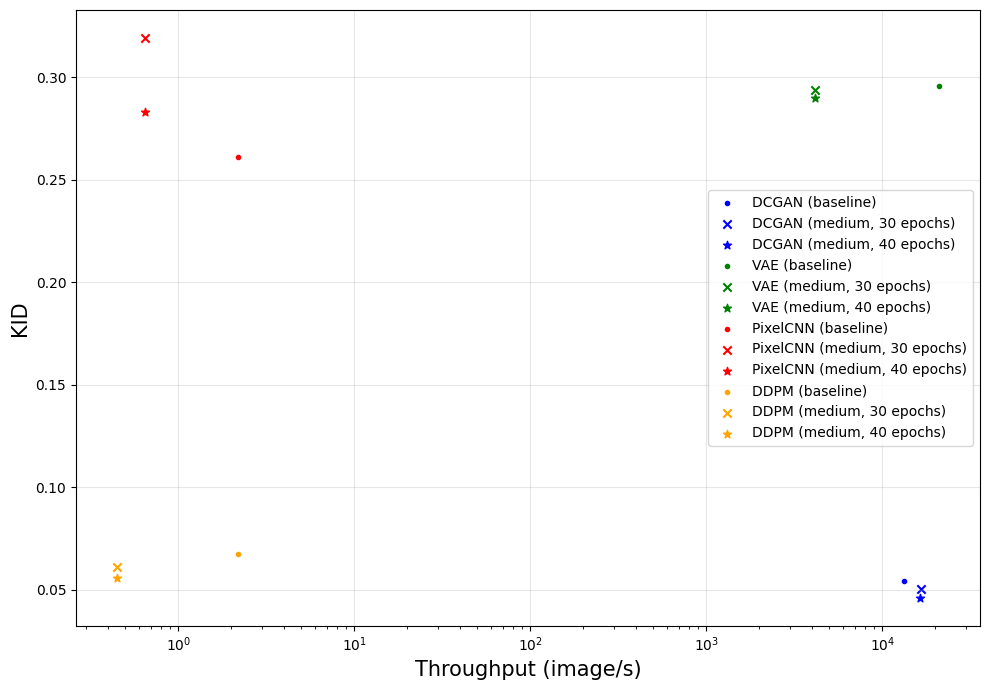

In [64]:
# Plot of throughput vs KID
with open('artifacts/metrics_summary.json') as f:
    data = json.load(f)
    throughput = np.array([data['DCGAN']['baseline']['throughput_img_per_s'],
                           data['DCGAN']['scaled-30ep']['throughput_img_per_s'],
                           data['DCGAN']['scaled-40ep']['throughput_img_per_s'],
                           data['VAE']['baseline']['throughput_img_per_s'],
                           data['VAE']['scaled-30ep']['throughput_img_per_s'],
                           data['VAE']['scaled-40ep']['throughput_img_per_s'],
                           data['PixelCNN']['baseline']['throughput_img_per_s'],
                           data['PixelCNN']['scaled-30ep']['throughput_img_per_s'],
                           data['PixelCNN']['scaled-40ep']['throughput_img_per_s'],
                           data['DDPM']['baseline']['throughput_img_per_s'],
                           data['DDPM']['scaled-30ep']['throughput_img_per_s'],
                           data['DDPM']['scaled-40ep']['throughput_img_per_s'],
    ])
    kid = np.array([data['DCGAN']['baseline']['kid'],
                           data['DCGAN']['scaled-30ep']['kid'],
                           data['DCGAN']['scaled-40ep']['kid'],
                           data['VAE']['baseline']['kid'],
                           data['VAE']['scaled-30ep']['kid'],
                           data['VAE']['scaled-40ep']['kid'],
                           data['PixelCNN']['baseline']['kid'],
                           data['PixelCNN']['scaled-30ep']['kid'],
                           data['PixelCNN']['scaled-40ep']['kid'],
                           data['DDPM']['baseline']['kid'],
                           data['DDPM']['scaled-30ep']['kid'],
                           data['DDPM']['scaled-40ep']['kid'],
    ])
    c=['blue','blue','blue','green','green','green','red','red','red','orange','orange','orange']
    marker=['.','x','*','.','x','*','.','x','*','.','x','*']
    label=['DCGAN (baseline)','DCGAN (medium, 30 epochs)','DCGAN (medium, 40 epochs)',
           'VAE (baseline)','VAE (medium, 30 epochs)','VAE (medium, 40 epochs)',
           'PixelCNN (baseline)','PixelCNN (medium, 30 epochs)','PixelCNN (medium, 40 epochs)',
           'DDPM (baseline)','DDPM (medium, 30 epochs)','DDPM (medium, 40 epochs)'
    ]
    fig, ax = plt.subplots(1,1,figsize=(10,7))
    for i in range(12):
        ax.scatter(x=throughput[i],y=kid[i],c=c[i],marker=marker[i],label=label[i])
    ax.set_xlabel('Throughput (image/s)',fontsize=15)
    ax.set_ylabel('KID', fontsize=15)
    ax.set_xscale('log')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('plots/throughput_kid.png', dpi=200)

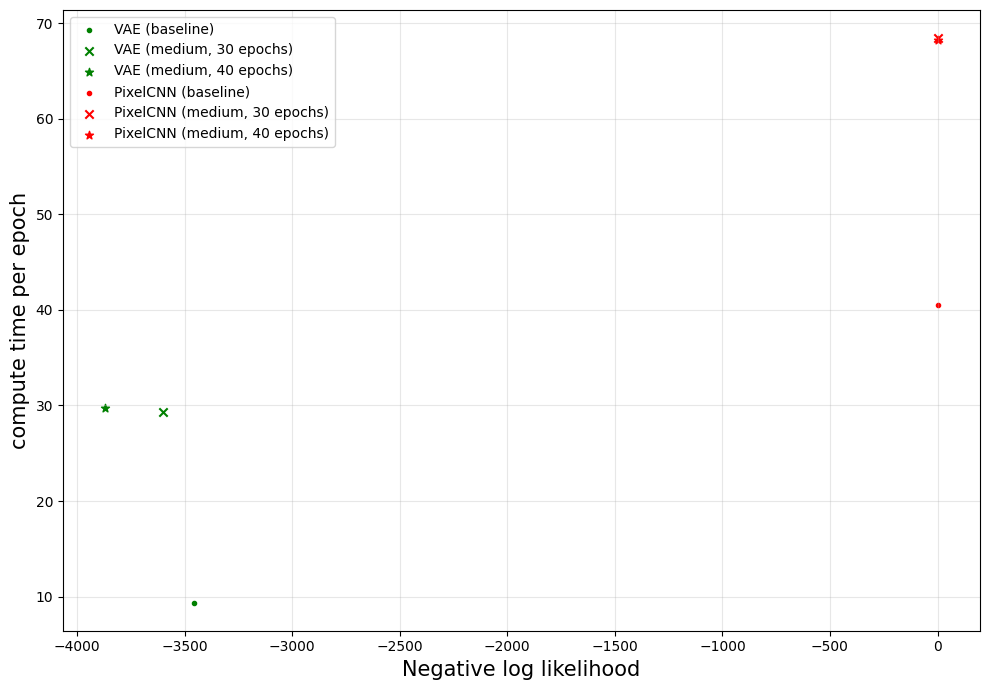

In [63]:
# Plot of compute versus negative log likelihood
with open('artifacts/metrics_summary.json') as f:
    data = json.load(f)
    nll = np.array([data['VAE']['baseline']['nll'],
                           data['VAE']['scaled-30ep']['nll'],
                           data['VAE']['scaled-40ep']['nll'],
                           data['PixelCNN']['baseline']['nll'],
                           data['PixelCNN']['scaled-30ep']['nll'],
                           data['PixelCNN']['scaled-40ep']['nll'],
    ])
    time = np.array([data['VAE']['baseline']['train_time_per_epoch_s'],
                           data['VAE']['scaled-30ep']['train_time_per_epoch_s'],
                           data['VAE']['scaled-40ep']['train_time_per_epoch_s'],
                           data['PixelCNN']['baseline']['train_time_per_epoch_s'],
                           data['PixelCNN']['scaled-30ep']['train_time_per_epoch_s'],
                           data['PixelCNN']['scaled-40ep']['train_time_per_epoch_s'],
    ])
    c=['green','green','green','red','red','red']
    marker=['.','x','*','.','x','*',]
    label=['VAE (baseline)','VAE (medium, 30 epochs)','VAE (medium, 40 epochs)',
           'PixelCNN (baseline)','PixelCNN (medium, 30 epochs)','PixelCNN (medium, 40 epochs)',
    ]
    fig, ax = plt.subplots(1,1,figsize=(10,7))
    ax.grid(alpha=0.3)
    for i in range(6):
        ax.scatter(x=nll[i],y=time[i],c=c[i],marker=marker[i],label=label[i])
    ax.set_xlabel('Negative log likelihood',fontsize=15)
    ax.set_ylabel('compute time per epoch', fontsize=15)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('plots/compute_nll.png', dpi=200)